# Combine metro-level network metrics from osmnx and momepy with census data 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

In [3]:
import pandas as pd
import os
import numpy as np

In [4]:
momepy_files = [fn for fn in os.listdir("../data/momepy/") if fn.endswith("measures.csv")]

In [5]:
dfs_momepy = []

for file in momepy_files:

    #fips = file.split('_')[0]

    df = pd.read_csv(f"../data/momepy/{file}", index_col=0).T

    dfs_momepy.append(df)
    df_momepy = pd.concat(dfs_momepy)

In [6]:
df_momepy

,cyclomatic,meshedness,gamma
40340,85031.0,0.946819,0.964547
39660,41253.0,0.847937,0.898627
15180,51254.0,0.927355,0.951571
43620,76821.0,0.873770,0.915848
45820,91218.0,0.952917,0.968612
...,...,...,...
13820,286075.0,0.782680,0.855120
14020,54908.0,0.844570,0.896381
16860,120368.0,0.747251,0.831502
49180,204430.0,0.715558,0.810373


In [7]:
files = [fn for fn in os.listdir("../data/metrics/") if fn.endswith("measures.csv")]

In [8]:
dfs = []

for file in files:

    fips = file.split('_')[0]

    df = pd.read_csv(f"../data/metrics/{file}")
    df['msa'] = fips
    df['node_props_dead_end'] = df.streets_per_node_proportions.iloc[1]
    df['node_props_3way'] = df.streets_per_node_proportions.iloc[3]
    df['node_props_4way'] = df.streets_per_node_proportions.iloc[4]
    
    # I think these "node proportion" measures are equivalent to "degree" in network science. I think they're gonna be critical but not 10)% on
    # how to operationalize them... do we need each? aggregate >4?, etc.
    
    df = df.groupby('msa').first()
    df = df.drop(columns=['streets_per_node_proportions', 'streets_per_node_counts', 'Unnamed: 0'])
    dfs.append(df)
    df = pd.concat(dfs).reset_index()

In [9]:
df = pd.concat(dfs)

In [10]:
#df.seg_difference.hist()

In [11]:
seg_diffs = pd.read_csv("../data/network_comparison.csv")

In [12]:
seg_diffs

,Unnamed: 0,fips,name,planar_measure,network_measure,seg_difference,p_value
0,0,10180,"Abilene, TX",0.103013,0.138835,0.035823,0.0732
1,1,10420,"Akron, OH",0.250862,0.288858,0.037996,0.0588
2,2,10500,"Albany, GA",0.305961,0.317874,0.011913,0.7482
3,3,10540,"Albany-Lebanon, OR",0.077134,0.111615,0.034481,0.1616
4,4,10580,"Albany-Schenectady-Troy, NY",0.158289,0.198885,0.040596,0.0124
...,...,...,...,...,...,...,...
375,375,49420,"Yakima, WA",0.204760,0.233521,0.028761,0.2710
376,376,49620,"York-Hanover, PA",0.210115,0.242871,0.032755,0.1028
377,377,49660,"Youngstown-Warren-Boardman, OH-PA",0.271484,0.320095,0.048611,0.0126
378,378,49700,"Yuba City, CA",0.088701,0.112363,0.023662,0.3578


In [13]:
seg_diffs.fips = seg_diffs.fips.astype(str)

In [14]:
df = df.merge(seg_diffs, left_index=True, right_on='fips', how='inner')

In [15]:
df

,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,...,node_props_dead_end,node_props_3way,node_props_4way,Unnamed: 0,fips,name,planar_measure,network_measure,seg_difference,p_value
97,23860,63104,5.289522,1.503965e+07,238.331192,2.652096,18346,7.519826e+06,31552,238.331192,...,0.231098,0.657460,0.108718,97,20020,"Dothan, AL",0.244834,0.252532,0.007698,0.8318
187,38486,103626,5.385127,2.278258e+07,219.853877,2.696045,29786,1.139129e+07,51813,219.853877,...,0.226056,0.628956,0.142078,187,29180,"Lafayette, LA",0.251438,0.279934,0.028497,0.2206
207,44855,117140,5.223052,2.475767e+07,211.351125,2.616297,34275,1.237884e+07,58570,211.351125,...,0.235871,0.677048,0.086211,207,30980,"Longview, TX",0.189522,0.180236,-0.009285,0.6396
285,40395,103126,5.105879,2.896298e+07,280.850398,2.556727,29301,1.448149e+07,51563,280.850398,...,0.274638,0.621067,0.102587,285,39820,"Redding, CA",0.083804,0.119905,0.036101,0.0036
70,349061,909164,5.209198,8.863501e+07,97.490672,2.605874,256810,4.431750e+07,454582,97.490672,...,0.264283,0.605788,0.126055,70,17140,"Cincinnati, OH-KY-IN",0.261561,0.315128,0.053567,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,58921,152620,5.180496,2.697433e+07,176.741778,2.592013,43909,1.348717e+07,76310,176.741778,...,0.254782,0.645746,0.097503,144,25060,"Gulfport-Biloxi, MS",0.219832,0.253415,0.033583,0.1348
118,55612,150458,5.410990,8.351319e+07,555.059812,2.710692,43767,4.175659e+07,75229,555.059812,...,0.212994,0.653043,0.131428,118,22380,"Flagstaff, AZ",0.076525,0.107445,0.030921,0.1168
365,16283,40706,4.999816,7.146691e+06,175.568503,2.506970,11451,3.573346e+06,20353,175.568503,...,0.296751,0.603574,0.098876,365,48260,"Weirton-Steubenville, WV-OH",0.215888,0.247097,0.031209,0.3450
105,70770,205420,5.805285,4.240018e+07,206.407278,2.904833,59889,2.120009e+07,102710,206.407278,...,0.153752,0.638321,0.204055,105,21340,"El Paso, TX",0.111886,0.138583,0.026697,0.0966


In [16]:
census = gpd.read_parquet("../data/census/msa_population.parquet")

In [17]:
df = df.merge(census, left_on='fips', right_on='GEOID')

In [18]:
df = df.merge(df_momepy, left_on='fips', right_index=True)

In [19]:
df['pct_diff'] = (df.seg_difference / df.planar_measure) * 100

In [20]:
df.loc[df.p_value <= 0.050, "significant"] = 1
df.significant=df.significant.fillna(0)

<AxesSubplot:>

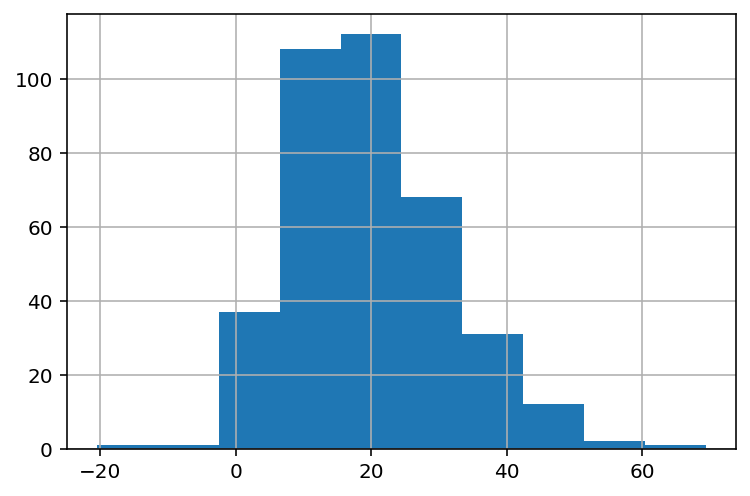

In [21]:
df.pct_diff.hist()

In [22]:
df = df.drop(columns=['Unnamed: 0']).set_index('fips')

In [23]:
df = df.drop(columns=['name_y', 'GEOID',])

In [24]:
df = df.rename(columns={'name_x': 'name'})

In [29]:
df = gpd.GeoDataFrame(df)

In [30]:
df.to_parquet("../data/model_data.parquet")

In [38]:
df.columns

Index(['n', 'm', 'k_avg', 'edge_length_total', 'edge_length_avg',
       'streets_per_node_avg', 'intersection_count', 'street_length_total',
       'street_segment_count', 'street_length_avg', 'circuity_avg',
       'self_loop_proportion', 'node_density_km', 'intersection_density_km',
       'edge_density_km', 'street_density_km', 'node_props_dead_end',
       'node_props_3way', 'node_props_4way', 'name', 'planar_measure',
       'network_measure', 'seg_difference', 'p_value', 'ALAND', 'AWATER',
       'population', 'pop_density', 'geometry', 'cyclomatic', 'meshedness',
       'gamma', 'pct_diff', 'significant'],
      dtype='object')

(22.0, 52.0)

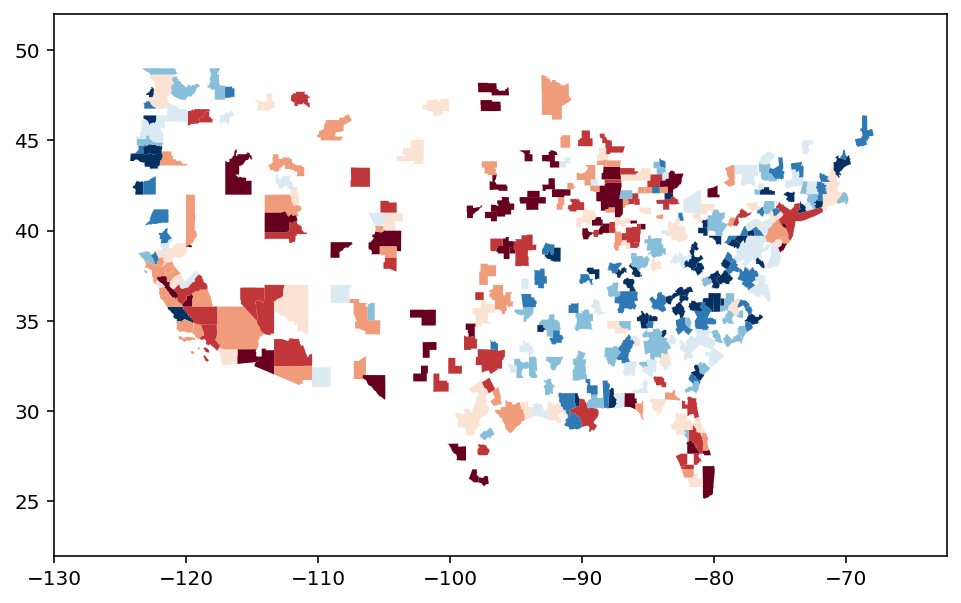

In [46]:
#df.explore('meshedness', scheme='quantiles', k=8, cmap='RdBu_r')
ax= df.plot('meshedness', scheme='quantiles', k=8, cmap='RdBu_r', figsize=(8,10))
ax.set_xlim(-130)
ax.set_ylim(22,52)

(22.0, 52.0)

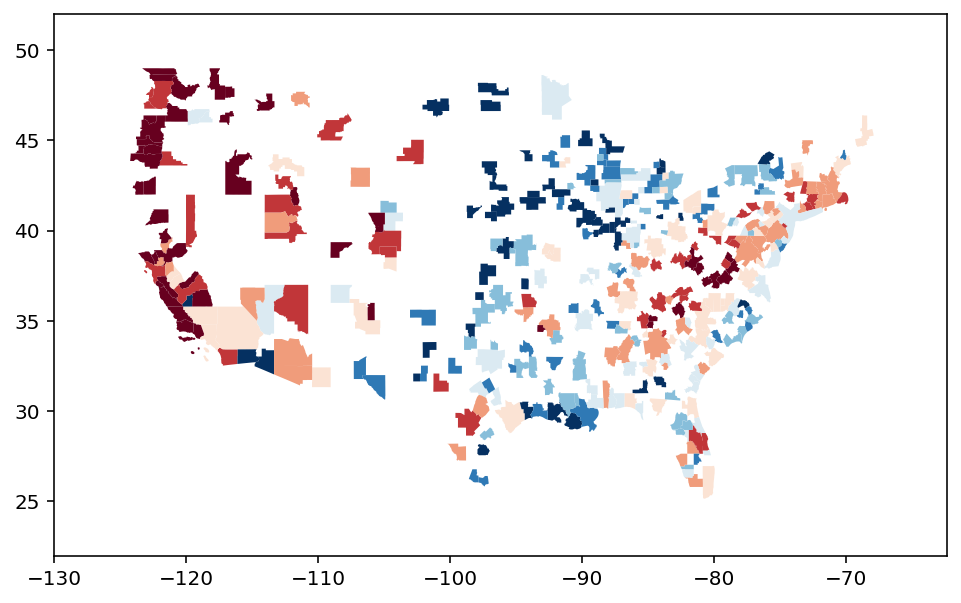

In [45]:
ax= df.plot('circuity_avg', scheme='quantiles', k=8, cmap='RdBu_r', figsize=(8,10))
ax.set_xlim(-130)
ax.set_ylim(22,52)

(22.0, 52.0)

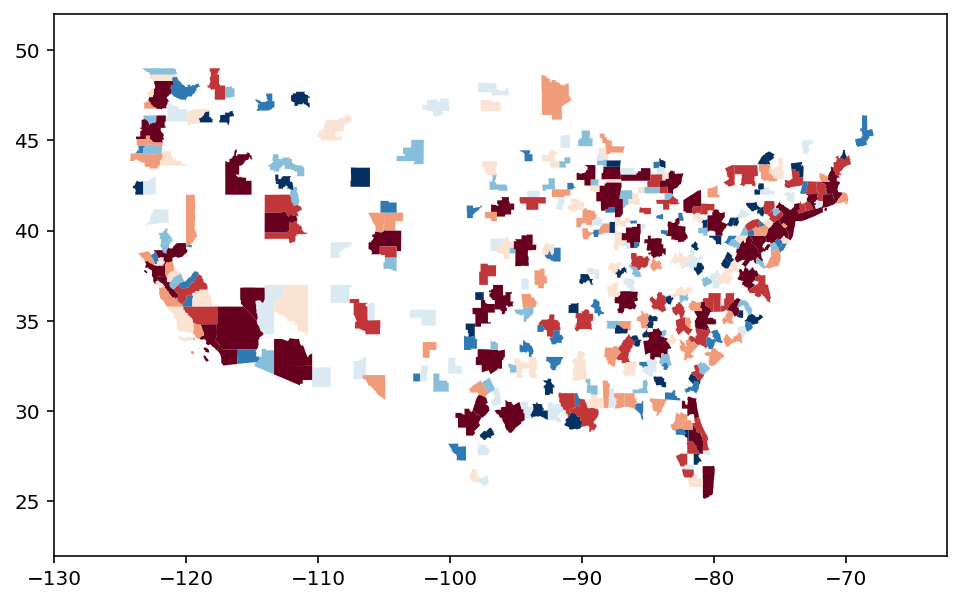

In [47]:
ax= df.plot('cyclomatic', scheme='quantiles', k=8, cmap='RdBu_r', figsize=(8,10))
ax.set_xlim(-130)
ax.set_ylim(22,52)